In [1]:
import os
import pandas as pd


spark_version = 'spark-3.0.2'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()


Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:7 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:9 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Ign:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Get:13 https://

In [2]:
# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("WSB").getOrCreate()

In [3]:
from google.colab import drive
drive.mount('/content/drive')
data_url = "/content/drive/MyDrive/Colab Notebooks/Butler-Project3-GroupA/Resources/"
os.chdir(data_url)

Mounted at /content/drive


In [4]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
file_name = "reddit_wsb_body_dropped.csv"
location = f"{data_url}{file_name}"
spark.sparkContext.addFile(location)
wsb_df = spark.read.csv(SparkFiles.get(file_name), sep=",", header=True, inferSchema=True, timestampFormat="yyyy/MM/dd HH:mm:ss" )

# Show DataFrame
wsb_df.show(100)

+--------------------+-----+------+--------------------+---------+----------+---------------+----+----+
|               title|score|    id|                 url|comms_num|   created|      timestamp| _c7| _c8|
+--------------------+-----+------+--------------------+---------+----------+---------------+----+----+
|It's not about th...|   55|l6ulcx|https://v.redd.it...|        6|1611862661|1/28/2021 21:37|null|null|
|Math Professor Sc...|  110|l6uibd|https://v.redd.it...|       23|1611862330|1/28/2021 21:32|null|null|
|     Exit the system|    0|l6uhhn|https://www.reddi...|       47|1611862235|1/28/2021 21:30|null|null|
|NEW SEC FILING FO...|   29|l6ugk6|https://sec.repor...|       74|1611862137|1/28/2021 21:28|null|null|
|Not to distract f...|   71|l6ufgy|https://i.redd.it...|      156|1611862016|1/28/2021 21:26|null|null|
| WE BREAKING THROUGH|  405|l6uf7d|https://i.redd.it...|       84|1611861990|1/28/2021 21:26|null|null|
|SHORT STOCK DOESN...|  317|l6uf6d|https://www.reddi...|       5

In [5]:
#convert to pandas
wsb_df_pd = wsb_df.toPandas()

wsb_df_pd

,title,score,id,url,comms_num,created,timestamp,_c7,_c8
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6,1611862661,1/28/2021 21:37,None,None
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23,1611862330,1/28/2021 21:32,None,None
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47,1611862235,1/28/2021 21:30,None,None
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74,1611862137,1/28/2021 21:28,None,None
4,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156,1611862016,1/28/2021 21:26,None,None
...,...,...,...,...,...,...,...,...,...
36556,Rant: Are any other financial services profess...,22,ls8cjp,https://www.reddit.com/r/wallstreetbets/commen...,15,1614293849,2/26/2021 0:57,None,None
36557,PLTR DIscussion + Strategy,63,ls8cf4,https://www.reddit.com/r/wallstreetbets/commen...,13,1614293840,2/26/2021 0:57,None,None
36558,NYSE already halted GME two times after market...,1289,ls88bk,https://www.reddit.com/r/wallstreetbets/commen...,171,1614293524,2/26/2021 0:52,None,None
36559,Even CNBC is now reporting that Melvin and Vla...,37242,ls84js,https://v.redd.it/id9cqgzeymj61,1941,1614293244,2/26/2021 0:47,None,None


In [6]:
!pip install -U arrow 

     |████████████████████████████████| 61kB 4.3MB/s 


In [7]:
#filter data
wsb_df_pd_filtered = wsb_df_pd[wsb_df_pd["title"].str.contains("GME" or "Gamestop", na=False)]

wsb_df_pd_filtered


,title,score,id,url,comms_num,created,timestamp,_c7,_c8
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74,1611862137,1/28/2021 21:28,None,None
4,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156,1611862016,1/28/2021 21:26,None,None
8,Currently Holding AMC and NOK - Is it retarded...,200,l6ub4i,https://i.redd.it/6k2z7ouo42e61.png,161,1611861556,1/28/2021 21:19,None,None
11,GME Premarket 🍁 Musk approved 🎮🛑💎✋,562,l6ua2q,https://i.redd.it/48rmgz5c42e61.png,97,1611861448,1/28/2021 21:17,None,None
12,"Once you're done with GME - $AG and $SLV, the ...",0,l6u9wu,https://www.reddit.com/r/wallstreetbets/commen...,16,1611861430,1/28/2021 21:17,None,None
...,...,...,...,...,...,...,...,...,...
36548,Crazy % gain on GME at open. Couldn’t get out ...,61,ls8o9u,https://i.redd.it/7p9j1yxo3nj61.jpg,16,1614294666,2/26/2021 1:11,None,None
36550,Cramer Confusion on GME 🦍🦍📈🤑,13837,ls8m0k,https://v.redd.it/wvtaqksz2nj61,1233,1614294517,2/26/2021 1:08,None,None
36555,Hypothesis on What's Happening with GME,101,ls8cky,https://www.reddit.com/r/wallstreetbets/commen...,44,1614293852,2/26/2021 0:57,None,None
36558,NYSE already halted GME two times after market...,1289,ls88bk,https://www.reddit.com/r/wallstreetbets/commen...,171,1614293524,2/26/2021 0:52,None,None


In [8]:
!pip install vaderSentiment

     |████████████████████████████████| 133kB 10.5MB/s 


In [9]:
# import SentimentIntensityAnalyzer class 
# from vaderSentiment.vaderSentiment module. 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
wsb_df_pd_filtered ["sentiment"] = ""
# Create a SentimentIntensityAnalyzer object. 
sid_obj = SentimentIntensityAnalyzer()
for index, row in wsb_df_pd_filtered.iterrows():
  sentence = row ["title"]
# polarity_scores method of SentimentIntensityAnalyzer 
# oject gives a sentiment dictionary. 
# which contains pos, neg, neu, and compound scores. 
  sentiment_dict = sid_obj.polarity_scores(sentence) 
  wsb_df_pd_filtered.at[index, "sentiment"] = sentiment_dict['compound']
wsb_df_pd_filtered.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,title,score,id,url,comms_num,created,timestamp,_c7,_c8,sentiment
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74,1611862137,1/28/2021 21:28,None,None,-0.3397
4,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156,1611862016,1/28/2021 21:26,None,None,0.2235
8,Currently Holding AMC and NOK - Is it retarded...,200,l6ub4i,https://i.redd.it/6k2z7ouo42e61.png,161,1611861556,1/28/2021 21:19,None,None,-0.5719
11,GME Premarket 🍁 Musk approved 🎮🛑💎✋,562,l6ua2q,https://i.redd.it/48rmgz5c42e61.png,97,1611861448,1/28/2021 21:17,None,None,0.5859
12,"Once you're done with GME - $AG and $SLV, the ...",0,l6u9wu,https://www.reddit.com/r/wallstreetbets/commen...,16,1611861430,1/28/2021 21:17,None,None,0


In [10]:
#import arrow and define date format
import arrow

arrow.utcnow().format('MM-DD-YYYY')

'03-06-2021'

In [11]:
#Create date convert fucntion
def date_convert(existingdate):
  new_date = existingdate.split(" ")[0]
  return new_date

In [12]:
#convert date and drop na
date = wsb_df_pd_filtered["timestamp"].apply(date_convert)
date = pd.to_datetime(date, infer_datetime_format=False, errors='coerce')  
wsb_df_pd_filtered["timestamp"] = date
wsb_df_pd_filtered = wsb_df_pd_filtered.dropna(subset= ["timestamp"])
wsb_df_pd_filtered

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,title,score,id,url,comms_num,created,timestamp,_c7,_c8,sentiment
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74,1611862137,2021-01-28,None,None,-0.3397
4,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156,1611862016,2021-01-28,None,None,0.2235
8,Currently Holding AMC and NOK - Is it retarded...,200,l6ub4i,https://i.redd.it/6k2z7ouo42e61.png,161,1611861556,2021-01-28,None,None,-0.5719
11,GME Premarket 🍁 Musk approved 🎮🛑💎✋,562,l6ua2q,https://i.redd.it/48rmgz5c42e61.png,97,1611861448,2021-01-28,None,None,0.5859
12,"Once you're done with GME - $AG and $SLV, the ...",0,l6u9wu,https://www.reddit.com/r/wallstreetbets/commen...,16,1611861430,2021-01-28,None,None,0
...,...,...,...,...,...,...,...,...,...,...
36548,Crazy % gain on GME at open. Couldn’t get out ...,61,ls8o9u,https://i.redd.it/7p9j1yxo3nj61.jpg,16,1614294666,2021-02-26,None,None,0.2732
36550,Cramer Confusion on GME 🦍🦍📈🤑,13837,ls8m0k,https://v.redd.it/wvtaqksz2nj61,1233,1614294517,2021-02-26,None,None,-0.296
36555,Hypothesis on What's Happening with GME,101,ls8cky,https://www.reddit.com/r/wallstreetbets/commen...,44,1614293852,2021-02-26,None,None,0
36558,NYSE already halted GME two times after market...,1289,ls88bk,https://www.reddit.com/r/wallstreetbets/commen...,171,1614293524,2021-02-26,None,None,0


In [13]:
#Groupby timestamp
wsb_df_ts = wsb_df_pd_filtered.groupby("timestamp").count()

wsb_df_ts

,title,score,id,url,comms_num,created,_c7,_c8,sentiment
timestamp,,,,,,,,,
2021-01-28,231,231,231,231,231,231,0,0,231
2021-01-29,2789,2789,2789,2789,2789,2789,0,0,2789
2021-01-30,282,282,282,282,282,282,0,0,282
2021-01-31,233,233,233,233,233,233,0,0,233
2021-02-01,198,198,198,198,198,198,0,0,198
2021-02-02,296,296,296,296,296,296,0,0,296
2021-02-03,511,511,511,511,511,511,0,0,511
2021-02-04,288,288,288,288,288,288,0,0,288
2021-02-05,525,525,525,525,525,525,0,0,525


In [14]:
#filter data
wsb_df_pd_filtered ["sentiment"] = pd.to_numeric(wsb_df_pd_filtered ["sentiment"])
wsb_df_pd_filtered.dtypes

wsb_df_pd_filtered_mean = wsb_df_pd_filtered.groupby("timestamp").mean()
wsb_df_pd_filtered_mean = wsb_df_pd_filtered_mean.reset_index()
wsb_df_pd_filtered_mean


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,timestamp,sentiment
0,2021-01-28,-0.025335
1,2021-01-29,-0.005534
2,2021-01-30,0.065801
3,2021-01-31,0.118177
4,2021-02-01,0.060673
5,2021-02-02,0.121892
6,2021-02-03,0.073366
7,2021-02-04,0.076034
8,2021-02-05,0.045861
9,2021-02-06,0.081364


In [15]:
#read CSV
gme_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Butler-Project3-GroupA/Resources/GME.csv")

gme_df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-09-28,10.160000,10.260000,9.550000,10.090000,10.090000,6764300
1,2020-09-29,10.000000,10.650000,9.930000,10.350000,10.350000,5237600
2,2020-09-30,10.250000,10.760000,10.060000,10.200000,10.200000,6079000
3,2020-10-01,10.090000,10.250000,9.690000,9.770000,9.770000,4554100
4,2020-10-02,9.380000,9.780000,9.300000,9.390000,9.390000,4340500
...,...,...,...,...,...,...,...
100,2021-02-22,46.689999,48.509998,42.400002,46.000000,46.000000,19338400
101,2021-02-23,44.970001,46.230000,40.000000,44.970001,44.970001,7516000
102,2021-02-24,44.700001,91.709999,44.700001,91.709999,91.709999,76315700
103,2021-02-25,169.559998,184.679993,101.000000,108.730003,108.730003,149282400


In [16]:
#convert date
date2 = gme_df["Date"].apply(date_convert)
date2 = pd.to_datetime(date2, format="%Y-%m-%d", infer_datetime_format=False, errors='coerce')  
gme_df["Date"] = date2

gme_df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-09-28,10.160000,10.260000,9.550000,10.090000,10.090000,6764300
1,2020-09-29,10.000000,10.650000,9.930000,10.350000,10.350000,5237600
2,2020-09-30,10.250000,10.760000,10.060000,10.200000,10.200000,6079000
3,2020-10-01,10.090000,10.250000,9.690000,9.770000,9.770000,4554100
4,2020-10-02,9.380000,9.780000,9.300000,9.390000,9.390000,4340500
...,...,...,...,...,...,...,...
100,2021-02-22,46.689999,48.509998,42.400002,46.000000,46.000000,19338400
101,2021-02-23,44.970001,46.230000,40.000000,44.970001,44.970001,7516000
102,2021-02-24,44.700001,91.709999,44.700001,91.709999,91.709999,76315700
103,2021-02-25,169.559998,184.679993,101.000000,108.730003,108.730003,149282400


In [17]:
#Merge dataframes
wsb_gme_raw = pd.merge(wsb_df_ts, gme_df, left_index=True, right_on="Date")

wsb_gme_raw

,title,score,id,url,comms_num,created,_c7,_c8,sentiment,Date,Open,High,Low,Close,Adj Close,Volume
84,231,231,231,231,231,231,0,0,231,2021-01-28,265.000000,483.000000,112.250000,193.600006,193.600006,58815800
85,2789,2789,2789,2789,2789,2789,0,0,2789,2021-01-29,379.709991,413.980011,250.000000,325.000000,325.000000,50259200
86,198,198,198,198,198,198,0,0,198,2021-02-01,316.559998,322.000000,212.000000,225.000000,225.000000,37382200
87,296,296,296,296,296,296,0,0,296,2021-02-02,140.759995,158.000000,74.220001,90.000000,90.000000,78183100
88,511,511,511,511,511,511,0,0,511,2021-02-03,112.010002,113.400002,85.250000,92.410004,92.410004,42698500
89,288,288,288,288,288,288,0,0,288,2021-02-04,91.190002,91.500000,53.330002,53.500000,53.500000,62427300
90,525,525,525,525,525,525,0,0,525,2021-02-05,54.040001,95.000000,51.090000,63.770000,63.770000,80886300
91,51,51,51,51,51,51,0,0,51,2021-02-08,72.410004,72.660004,58.020000,60.000000,60.000000,25687300
92,32,32,32,32,32,32,0,0,32,2021-02-09,56.610001,57.000000,46.520000,50.310001,50.310001,26843100
93,42,42,42,42,42,42,0,0,42,2021-02-10,50.770000,62.830002,46.549999,51.200001,51.200001,36455000


In [18]:
#merged sentiment, disregard sentiment_x, sentiment_y is average/date
wsb_gme_raw = pd.merge(wsb_gme_raw, wsb_df_pd_filtered_mean, left_on= "Date", right_on="timestamp")

wsb_gme_raw

,title,score,id,url,comms_num,created,_c7,_c8,sentiment_x,Date,Open,High,Low,Close,Adj Close,Volume,timestamp,sentiment_y
0,231,231,231,231,231,231,0,0,231,2021-01-28,265.000000,483.000000,112.250000,193.600006,193.600006,58815800,2021-01-28,-0.025335
1,2789,2789,2789,2789,2789,2789,0,0,2789,2021-01-29,379.709991,413.980011,250.000000,325.000000,325.000000,50259200,2021-01-29,-0.005534
2,198,198,198,198,198,198,0,0,198,2021-02-01,316.559998,322.000000,212.000000,225.000000,225.000000,37382200,2021-02-01,0.060673
3,296,296,296,296,296,296,0,0,296,2021-02-02,140.759995,158.000000,74.220001,90.000000,90.000000,78183100,2021-02-02,0.121892
4,511,511,511,511,511,511,0,0,511,2021-02-03,112.010002,113.400002,85.250000,92.410004,92.410004,42698500,2021-02-03,0.073366
5,288,288,288,288,288,288,0,0,288,2021-02-04,91.190002,91.500000,53.330002,53.500000,53.500000,62427300,2021-02-04,0.076034
6,525,525,525,525,525,525,0,0,525,2021-02-05,54.040001,95.000000,51.090000,63.770000,63.770000,80886300,2021-02-05,0.045861
7,51,51,51,51,51,51,0,0,51,2021-02-08,72.410004,72.660004,58.020000,60.000000,60.000000,25687300,2021-02-08,0.108000
8,32,32,32,32,32,32,0,0,32,2021-02-09,56.610001,57.000000,46.520000,50.310001,50.310001,26843100,2021-02-09,0.120531
9,42,42,42,42,42,42,0,0,42,2021-02-10,50.770000,62.830002,46.549999,51.200001,51.200001,36455000,2021-02-10,-0.090019


In [19]:
#save to csv
wsb_gme_raw.to_csv(r'wsb_gme.csv', index = False, header=True)

In [20]:
#Change date format
wsb_gme = wsb_gme_raw["Date"].dt.strftime("%Y%m%d").astype(int)

wsb_gme

0     20210128
1     20210129
2     20210201
3     20210202
4     20210203
5     20210204
6     20210205
7     20210208
8     20210209
9     20210210
10    20210211
11    20210212
12    20210216
13    20210217
14    20210218
15    20210219
16    20210222
17    20210223
18    20210224
19    20210225
20    20210226
Name: Date, dtype: int64

In [21]:
#Import matplotlib and numpy
import matplotlib.pyplot as plt
import numpy as np

In [97]:
#Define and print data
X = wsb_gme_raw[['title', 'Close', 'sentiment_y']]
y = wsb_gme.values.reshape(-1,1)

print(X.shape, y.shape)

(21, 3) (21, 1)


In [98]:
# Split the data into training and testing


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


In [99]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScater model and fit it to the training data


X_scaler = StandardScaler().fit(X)
y_scaler = StandardScaler().fit(y)


In [100]:
#Transform data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)



In [103]:
#Import Linear Regression and create model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train_scaled, y_train_scaled)
print(X_train_scaled, y_train_scaled)

[[-0.41865448 -0.5212546  -0.77344817]
 [ 0.07430874  0.00792836  0.97233854]
 [-0.38805676  0.03199491  0.87351233]
 [-0.40505549 -0.61132833 -0.09043051]
 [-0.40675537 -0.61217278 -2.55833635]
 [-0.09227883  1.90792045  0.15985944]
 [-0.35745905 -0.53814343 -1.84008066]
 [-0.22996856  0.17315727  1.47531366]
 [ 0.43978147  0.04184679  0.32831575]
 [-0.42545397 -0.56192856 -1.31493282]
 [-0.34216019 -0.41429211  0.78796528]
 [-0.39995587 -0.53955088  0.67523405]
 [-0.38805676 -0.68606136  0.1348879 ]
 [-0.34386006  0.27153471  0.90950735]
 [ 0.4635797  -0.36123307 -0.03672191]] [[ 0.25536308]
 [-0.12768154]
 [ 0.71501663]
 [ 0.6384077 ]
 [ 0.44688539]
 [-0.165986  ]
 [ 0.17875416]
 [ 0.79162555]
 [-0.08937708]
 [ 0.40858093]
 [ 0.10214523]
 [ 0.21705862]
 [ 0.48518985]
 [ 0.75332109]
 [-0.01276815]]


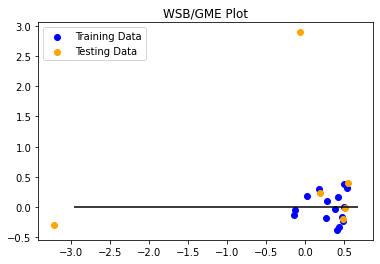

In [104]:
#Make Predictions and Plot
predictions = model.predict(X_test_scaled)
unscaled_predictions = y_scaler.inverse_transform(predictions)
predictions = unscaled_predictions
model.fit(X_train_scaled, y_train_scaled)
plt.scatter(model.predict(X_train_scaled), model.predict(X_train_scaled) - y_train_scaled, c="blue", label="Training Data")
plt.scatter(model.predict(X_test_scaled), model.predict(X_test_scaled) - y_test_scaled, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test_scaled.min(), xmax=y_test_scaled.max())
plt.title("WSB/GME Plot")
plt.show()

In [109]:
#import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor


In [110]:
#create and fit model
model1 = RandomForestRegressor(random_state=42)

model1.fit(X_train_scaled,y_train_scaled.ravel())


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [111]:

#Make Predictions
pred = model1.predict(X_test_scaled)


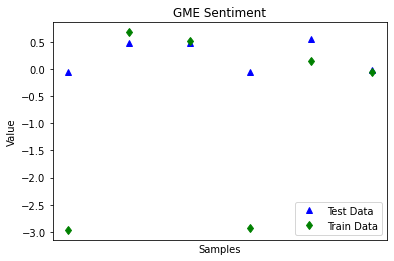

In [113]:
#Plot Train and Test Data
plt.figure()
plt.plot(pred, 'b^', label='Test Data')
plt.plot(y_test_scaled, 'gd', label='Train Data')
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('Value')
plt.xlabel('Samples')
plt.legend(loc="best")
plt.title('GME Sentiment')

plt.show()

In [105]:
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = model.score(X_test_scaled, y_test_scaled)


print(f"MSE: {MSE}, R2: {r2}")

MSE: 408452155417524.44, R2: 0.40135862083357177


In [106]:
from sklearn.linear_model import Lasso


lasso = Lasso(alpha=.01).fit(X_train_scaled, y_train_scaled)

predictions = lasso.predict(X_test_scaled)

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = lasso.score(X_test_scaled, y_test_scaled)


print(f"MSE: {MSE}, R2: {r2}")

MSE: 1.5313473739879113, R2: 0.3688156973496943


In [107]:
from sklearn.linear_model import Ridge


ridge = Ridge(alpha=.01).fit(X_train_scaled, y_train_scaled)

predictions = ridge.predict(X_test_scaled)

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = ridge.score(X_test_scaled, y_test_scaled)


print(f"MSE: {MSE}, R2: {r2}")

MSE: 1.4508098919265873, R2: 0.4020112970650661


In [108]:
from sklearn.linear_model import ElasticNet


elasticnet = ElasticNet(alpha=.01).fit(X_train_scaled, y_train_scaled)

predictions = elasticnet.predict(X_test_scaled)

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = elasticnet.score(X_test_scaled, y_test_scaled)


print(f"MSE: {MSE}, R2: {r2}")

MSE: 1.4855984596328458, R2: 0.3876722919373824
